In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'

extracted_features_dir = "extracted_features/"
model_name = "DenseNet201_pooling_512"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448


In [46]:
output_classes = 4
batch_size = 32
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 200

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)

train samples: 4608
test samples: 1792


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 108
predict_size_validation: 36

 num_classes: 4


In [8]:
bottleneck_base_model = applications.DenseNet201(include_top=False,  pooling = 'avg', weights='imagenet')

bottleneck_base_model = Model(input=bottleneck_base_model.input, output = bottleneck_base_model.layers[-2].output)
bottleneck_top_model = Sequential()
bottleneck_top_model.add(AveragePooling2D((3, 3), name='avg_pool', input_shape=input_shape))

bottleneck_final_model = Sequential()
bottleneck_final_model.add(bottleneck_base_model)
bottleneck_final_model.add(bottleneck_top_model)

In [9]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 1792 images belonging to 4 classes.


In [12]:
nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

nb_test_samples: 1792
predict_size_test: 56


In [13]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [14]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [47]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3456 samples, validate on 1152 samples
Epoch 1/200
 - 7s - loss: 1.2538 - acc: 0.4650 - val_loss: 0.8101 - val_acc: 0.7222
Epoch 2/200
 - 2s - loss: 0.7826 - acc: 0.6869 - val_loss: 0.6135 - val_acc: 0.7925
Epoch 3/200
 - 2s - loss: 0.5804 - acc: 0.7940 - val_loss: 0.4673 - val_acc: 0.8715
Epoch 4/200
 - 2s - loss: 0.4424 - acc: 0.8547 - val_loss: 0.3759 - val_acc: 0.8906
Epoch 5/200
 - 2s - loss: 0.3444 - acc: 0.8935 - val_loss: 0.3194 - val_acc: 0.9062
Epoch 6/200
 - 2s - loss: 0.2763 - acc: 0.9219 - val_loss: 0.2584 - val_acc: 0.9384
Epoch 7/200
 - 2s - loss: 0.2213 - acc: 0.9439 - val_loss: 0.2180 - val_acc: 0.9462
Epoch 8/200
 - 2s - loss: 0.1826 - acc: 0.9609 - val_loss: 0.1866 - val_acc: 0.9583
Epoch 9/200
 - 2s - loss: 0.1537 - acc: 0.9647 - val_loss: 0.1632 - val_acc: 0.9609
Epoch 10/200
 - 2s - loss: 0.1249 - acc: 0.9786 - val_loss: 0.1415 - val_acc: 0.9757
Epoch 11/200
 - 2s - loss: 0.1093 - acc: 0.9792 - val_loss: 0.1279 - val_acc: 0.9731
Epoch 12/200
 - 2s - loss:

Epoch 97/200
 - 2s - loss: 5.1293e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9948
Epoch 98/200
 - 2s - loss: 4.4068e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 0.9948
Epoch 99/200
 - 2s - loss: 3.9821e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 0.9957
Epoch 100/200
 - 2s - loss: 4.0653e-04 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 0.9948
Epoch 101/200
 - 2s - loss: 3.9411e-04 - acc: 1.0000 - val_loss: 0.0099 - val_acc: 0.9957
Epoch 102/200
 - 2s - loss: 7.3816e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9948
Epoch 103/200
 - 2s - loss: 4.0919e-04 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9974
Epoch 104/200
 - 2s - loss: 4.4807e-04 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9957
Epoch 105/200
 - 2s - loss: 5.5902e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9957
Epoch 106/200
 - 2s - loss: 4.4027e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 0.9948
Epoch 107/200
 - 2s - loss: 3.3648e-04 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.9948
Epoch 108/200

 - 2s - loss: 3.3836e-05 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9974
Epoch 189/200
 - 3s - loss: 3.4466e-05 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9974
Epoch 190/200
 - 3s - loss: 3.9512e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9974
Epoch 191/200
 - 2s - loss: 3.1985e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9983
Epoch 192/200
 - 2s - loss: 2.2737e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9991
Epoch 193/200
 - 2s - loss: 2.3030e-05 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9974
Epoch 194/200
 - 2s - loss: 4.7731e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9983
Epoch 195/200
 - 2s - loss: 3.5618e-05 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9983
Epoch 196/200
 - 2s - loss: 1.8990e-05 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9974
Epoch 197/200
 - 2s - loss: 2.6468e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9974
Epoch 198/200
 - 2s - loss: 1.8347e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9974
Epoch 199/200
 - 2s - lo

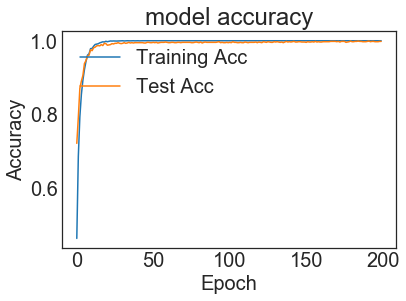

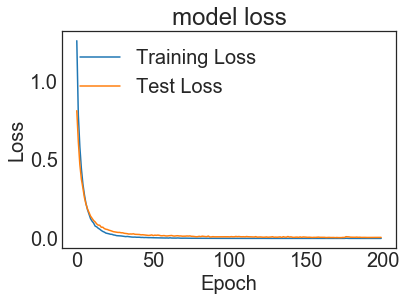

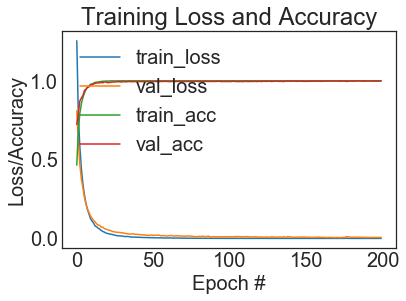

In [48]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [49]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 386us/step
Validation Accuracy: 99.8264%
Validation Loss: 0.006535001645362273


In [50]:
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [51]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8465401785714286


Confusion Matrix
[[399  29  16   4]
 [ 61 363  20   4]
 [ 32  49 365   2]
 [ 47  11   0 390]]


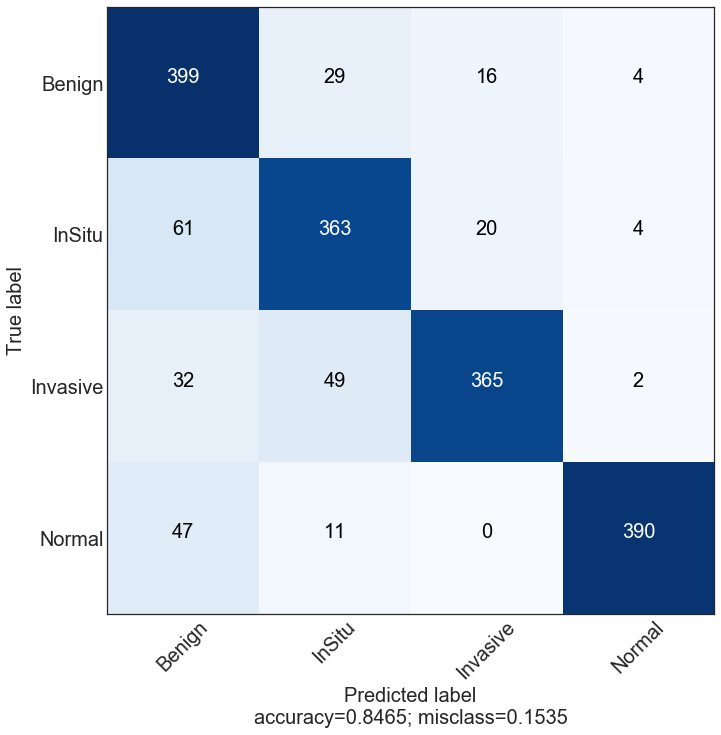

In [52]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[399  29  16   4]
 [ 61 363  20   4]
 [ 32  49 365   2]
 [ 47  11   0 390]]
              precision    recall  f1-score   support

      InSitu       0.74      0.89      0.81       448
      Normal       0.80      0.81      0.81       448
      Benign       0.91      0.81      0.86       448
    Invasive       0.97      0.87      0.92       448

   micro avg       0.85      0.85      0.85      1792
   macro avg       0.86      0.85      0.85      1792
weighted avg       0.86      0.85      0.85      1792



In [54]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.73913043478261
Specificity :  92.60204081632652


____
# test without augmentation

In [55]:
test_dir_whithout_aug = "data/512/test-without-aug/"
test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

print("nb_test_samples:", nb_test_without_aug_samples)
print("predict_size_test:", predict_size_test_without_aug)

Found 112 images belonging to 4 classes.
nb_test_samples: 112
predict_size_test: 4


In [56]:
bottleneck_features_test_without_aug = bottleneck_final_model.predict_generator(test_generator_without_aug, predict_size_test_without_aug)
np.save(extracted_features_dir+'bottleneck_features_test_without_aug_'+model_name+'.npy', bottleneck_features_test_without_aug)

In [57]:
test_data_without_aug = np.load(extracted_features_dir+'bottleneck_features_test_without_aug_'+model_name+'.npy')

test_labels_without_aug = test_generator_without_aug.classes
test_labels_without_aug = to_categorical(test_labels_without_aug, num_classes=num_classes)

In [58]:
preds = model.predict(test_data_without_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8571428571428571


Confusion Matrix
[[26  1  0  1]
 [ 4 23  1  0]
 [ 2  4 22  0]
 [ 3  0  0 25]]


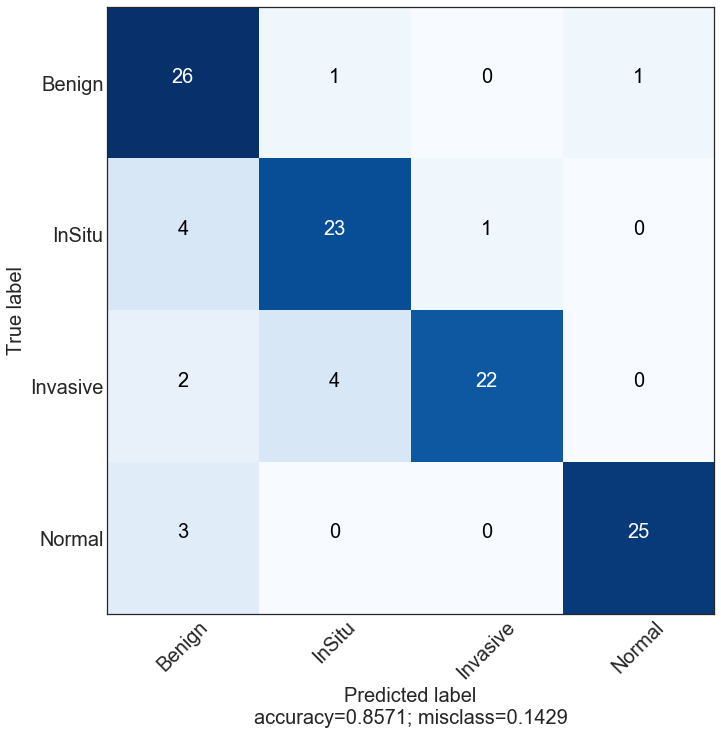

In [59]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[26  1  0  1]
 [ 4 23  1  0]
 [ 2  4 22  0]
 [ 3  0  0 25]]
              precision    recall  f1-score   support

      InSitu       0.74      0.93      0.83        28
      Normal       0.82      0.82      0.82        28
      Benign       0.96      0.79      0.86        28
    Invasive       0.96      0.89      0.93        28

   micro avg       0.86      0.86      0.86       112
   macro avg       0.87      0.86      0.86       112
weighted avg       0.87      0.86      0.86       112



In [61]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.66666666666667
Specificity :  95.83333333333334
